# Task 2b: Extracting data from OCR'd PDFs

Import the needed libraries. We'll be using the amazing [pdfplumber](https://github.com/jsvine/pdfplumber) to gather lines from the account PDF.

In [1]:
import pdfplumber
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from decimal import Decimal
import re

%matplotlib inline

Function for printing a diagram with the boundaries of the words on a page.

In [2]:
def print_words(p):
    fig = plt.figure(figsize=(4,6))
    ax = fig.add_axes([0,0,1,1]) 
    _ = ax.set_xlim(left=0, right=int(p.width))
    _ = ax.set_ylim(top=0, bottom=int(p.height))
    for i in p.extract_words():
        r = Rectangle(
            # (left, bottom), width, height,
            (i['x0'], i['bottom']), (i['x1'] - i['x0']), (i['top'] - i['bottom']),
            color='blue'
        )
        r = ax.add_patch(r)

## Get a sample PDF

This is a PDF that has been OCR'ed using the process in task 2a. The `p` variable represents the page with the Balance Sheet on.

In [4]:
pdf = pdfplumber.open("test_accounts.pdf")
p = pdf.pages[19]

Here's a representation of what the page looks like.

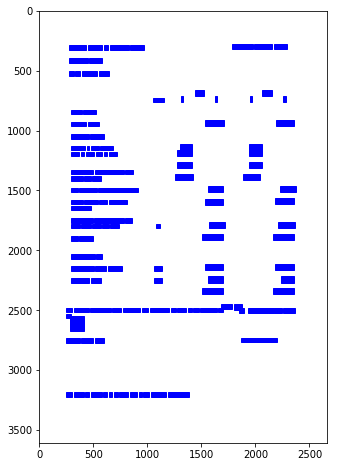

In [5]:
print_words(p)

## Approach 1: Use inbuilt `extract_table` function

This approach does find a table, but it's not great for getting at the data within.

In [6]:
pd.DataFrame(p.extract_table({
    "horizontal_strategy": "text",
    "vertical_strategy": "text",
    "snap_tolerance": 6,
    "join_tolerance": 2,
}))

,0,1,2,3,4,5,6
0,None,None,None,None,,None,
1,None,None,None,None,"1,643,616",None,"1,525,743"
2,None,None,None,None,,None,
3,CURRENT ASSETS,None,None,None,,None,
4,,None,None,None,,None,
5,,None,None,None,,,
6,"39,662\nDebtors & other assets",None,None,None,,"26,300",
7,,None,None,,,,
8,Cash at bank and in hand,None,None,"289,743",,"58,342",
9,,None,None,,,,


## Approach 2: Detecting lines

This function should output a series of recetangles giving separated lines in a PDF page. It's based on finding gaps between lines, so relies on there being vertical white space.

In [7]:
def detect_lines(p, x_tolerance=0):
    """
    Detect lines in a PDF page
    """
    cells = pd.DataFrame(p.extract_words(x_tolerance=x_tolerance)).sort_values(["top", "x0"])
    row_ranges = []
    this_range = []
    for i in range(0, int(p.height)):
        result = ((cells['bottom'] >= i) & (cells['top'] <= i)).sum()>0
        if result:
            this_range.append(i)
        else:
            if this_range:
                row_ranges.append(this_range)
            this_range = []
    # create bounding boxes: (x0, top, x1, bottom)
    return [{
        "x0": 0,
        "top": min(r),
        "x1": p.width,
        "bottom": max(r)
    } for r in row_ranges]

Draw a picture of the page with the lines highlighted.

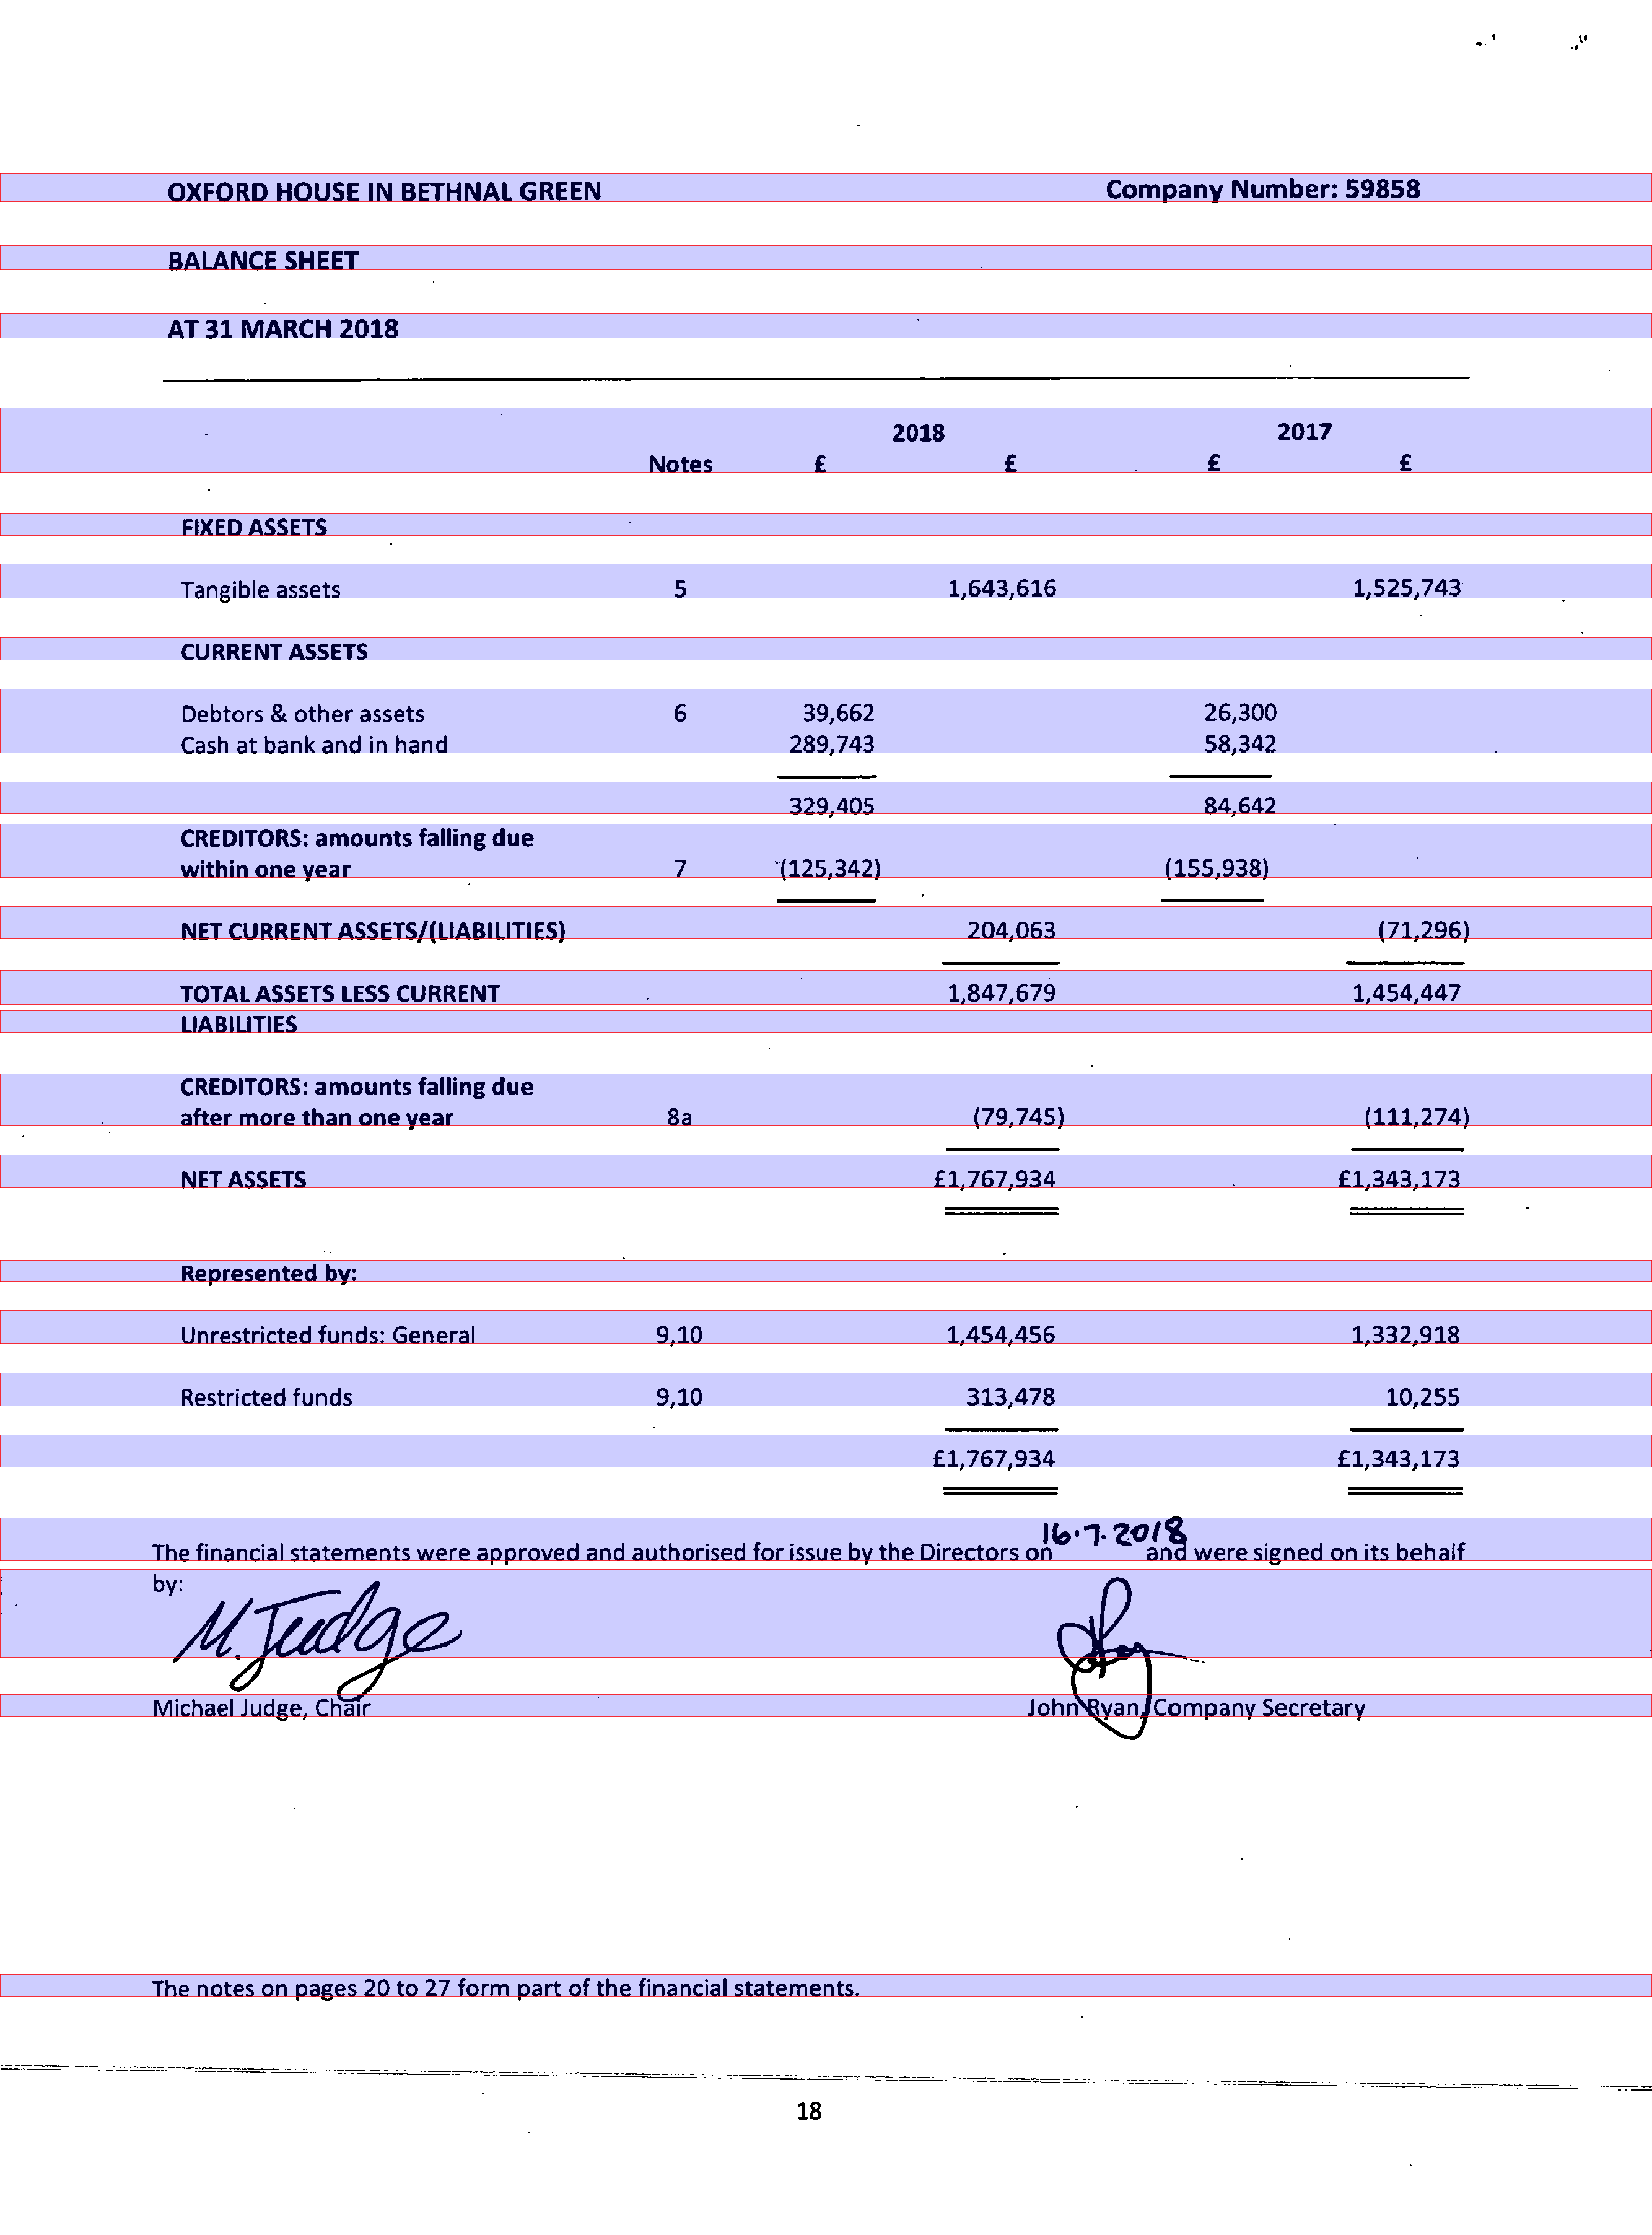

In [8]:
im = p.to_image()
im.draw_rects(detect_lines(p, 0))

## Approach 3: Use the `extract_text` function to get lines

Once the lines have been found, use a regex to find the data.

In [9]:
p.extract_text(y_tolerance=30).split('\n')

['OXFORD HOUSE IN BETHNAL GREEN Company Number: 59858',
 'BALANCE SHEET',
 'AT 31 MARCH 2018',
 '2018 2017',
 'Notes £ £ £ £',
 'FIXED ASSETS',
 'Tangible assets 1,643,616 1,525,743',
 'CURRENT ASSETS',
 'Debtors & other assets 39,662 26,300',
 'Cash at bank and in hand 289,743 58,342',
 '329,405 84,642',
 'CREDITORS: amountsfalling due',
 'within one year (125,342) (155,938)',
 'NET CURRENT ASSETS/(LIABILITIES) 204,063 (71,296)',
 'TOTAL ASSETS LESS CURRENT 1,847,679 1,454,447',
 'LIABILITIES',
 'CREDITORS: amountsfalling due',
 'after more than one year 8a (79,745) (111,274)',
 'NET ASSETS £1,767,934 £1,343,173',
 'Represented by:',
 'Unrestricted funds: General 9,10 1,454,456 1,332,918',
 'Restricted funds 9,10 313,478 10,255',
 '£1,767,934 £1,343,173',
 'The financial statements were approved and authorised for issue by the Directors onI o}. 2 oland weresigned on its behalf',
 'byM: M,',
 'Michael Judge, Chair Company Secretary',
 'The notes on pages 20 to 27 form part of the finan

In [10]:
def get_finances(pdf):
    
    finance_regex = r'(.*)\s+(\(?\-?[\,0-9]+\)?)\s+(\(?\-?[\,0-9]+\)?)$'
    
    def process_match(match):
        match = {
            "text": match[0],
            "value1": match[1],
            "value2": match[2]
        }
        for i in ("value1", "value2"):
            match[i] = match[i].replace(",", "")
            if match[i][0] == "(" and match[i][-1] == ")":
                match[i] = match[i].replace("(", "-").replace(")", "")
            match[i] = float(match[i])
        return match
    
    finances = []
    for ps in pdf.pages:
        for l in ps.extract_text(y_tolerance=20).split('\n'):
            match = re.search(finance_regex, l)
            if match:
                m = process_match(match.groups())
                m['page'] = ps.page_number
                finances.append(m)
                
    return pd.DataFrame(finances)

In [11]:
get_finances(pdf)

,page,text,value1,value2
0,14,Phone 0207,739.0,9001.0
1,19,Funds Funds,2018.0,2017.0
2,19,"Grants 3 461,010",461010.0,77732.0
3,19,"Donations 3 2,482",2482.0,62988.0
4,19,"Rental income 369,392 *",369392.0,372051.0
5,19,Other 15,15.0,2588.0
6,19,"Costs associated with rental income 133,059",133059.0,129969.0
7,19,Provision of community facilities and services...,275079.0,372599.0
8,19,"Total. . 4 388,649 19,489",408138.0,502568.0
9,19,"(19,242) 444,003",424761.0,12791.0


## Test on a random sample of accounts

In [89]:
# get a random sample of accounts to look at
import os
import random

In [90]:
accounts = {"charity": [], "company_ixbrl": [], "company_pdf": []}
for a in os.listdir("accounts"):
    if a.startswith("GB-CHC"):
        accounts["charity"].append(a)
    elif a.startswith("GB-COH"):
        if a.endswith(".html"):
            accounts["company_ixbrl"].append(a)
        elif a.endswith(".pdf"):
            accounts["company_pdf"].append(a)
accounts

{'charity': ['GB-CHC-1000544-2017-03-31.pdf',
  'GB-CHC-1001463-2017-03-31.pdf',
  'GB-CHC-1002722-2017-06-30.pdf',
  'GB-CHC-1003257-2017-03-31.pdf',
  'GB-CHC-1003505-2017-03-31.pdf',
  'GB-CHC-1006504-2017-03-31.pdf',
  'GB-CHC-1007165-2018-03-31.pdf',
  'GB-CHC-1011495-2018-03-31.pdf',
  'GB-CHC-1014416-2018-03-31.pdf',
  'GB-CHC-1017481-2017-03-31.pdf',
  'GB-CHC-1018758-2017-03-31.pdf',
  'GB-CHC-1023032-2017-03-31.pdf',
  'GB-CHC-1024544-2017-03-31.pdf',
  'GB-CHC-1026487-2017-08-31.pdf',
  'GB-CHC-1026620-2017-03-31.pdf',
  'GB-CHC-1028464-2017-03-31.pdf',
  'GB-CHC-1033067-2017-03-31.pdf',
  'GB-CHC-1035308-2017-03-31.pdf',
  'GB-CHC-1035811-2017-08-31.pdf',
  'GB-CHC-1036460-2017-03-31.pdf',
  'GB-CHC-1037582-2018-03-31.pdf',
  'GB-CHC-1040519-2017-12-31.pdf',
  'GB-CHC-1041653-2017-06-30.pdf',
  'GB-CHC-1042095-2017-03-31.pdf',
  'GB-CHC-1044103-2017-03-31.pdf',
  'GB-CHC-1045695-2017-03-31.pdf',
  'GB-CHC-1045781-2018-03-31.pdf',
  'GB-CHC-1047148-2017-03-31.pdf',
  'GB-CHC

In [91]:
charity_sample =random.sample(accounts["charity"], 10)

In [92]:
assets_regex = r'(total net assets|net (total )?assets)'

In [108]:
for c in charity_sample:
    c
    cpdf = pdfplumber.open(os.path.join("accounts", c))
    try:
        df = get_finances(cpdf)
    except:
        continue
    if not isinstance(df, pd.DataFrame) or 'text' not in df.columns:
        continue
    assets = df[df["text"].str.contains(assets_regex, case=False)]
    if assets.size > 0:
        assets

'GB-CHC-1074800-2018-03-31.pdf'

c:\users\drkan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # Remove the CWD from sys.path while we load stuff.


'GB-CHC-1086183-2017-03-31.pdf'

'GB-CHC-1120494-2017-12-31.pdf'

'GB-CHC-1159624-2017-03-31.pdf'

'GB-CHC-1116147-2017-08-30.pdf'

'GB-CHC-1107400-2017-08-31.pdf'

,page,text,value1,value2
5,7,Total net assets,41155.0,33699.0


'GB-CHC-1156904-2017-03-31.pdf'

'GB-CHC-1063275-2018-03-31.pdf'

'GB-CHC-1088751-2017-03-31.pdf'

'GB-CHC-1037582-2018-03-31.pdf'